In [3]:
from neo4j import GraphDatabase
import pandas as pd
import warnings
from neo4j import GraphDatabase
from dotenv import load_dotenv
load_dotenv()
import xgboost as xgb
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle

# NumPy関連のRuntimeWarningを無効化
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
# DB接続処理
# Neo4jに接続
uri = "bolt://localhost:7687"
user = "neo4j"
password = "abcd7890"

# ドライバを作成
driver = GraphDatabase.driver(uri, auth=(user, password))

In [5]:
# レシピのページランクやAromaのページランクを取得する
# FIX THIS CODE
def drop_projection_graph(tx):
    query = """
    CALL gds.graph.drop('PageRank')
    """
    tx.run(query)
    
def create_projection_graph(tx):
    query = """
    CALL gds.graph.project.cypher(
      'PageRank',
      'MATCH (n) 
      WHERE n:Food OR n:Aroma
      RETURN id(n) AS id, labels(n) AS labels',
      'MATCH (n)-[r:SCENTED]-(m) 
      RETURN id(n) AS source, id(m) AS target, type(r) AS type',
      { validateRelationships: false }
    )
    """
    tx.run(query)

def write_page_rank(tx):
    query = """
        CALL gds.pageRank.stream('PageRank')
        YIELD nodeId, score
        MATCH (n) WHERE id(n) = nodeId
        SET n.pagerank = score
        RETURN n.name, n.pagerank
        ORDER BY score DESC;
    """
    tx.run(query)

def write_popularity(tx):
    query = """
        MATCH (f:Food)
        OPTIONAL MATCH (f)-[r:USED_TOGETHER]->(f2:Food)
        WITH f, COUNT(r) AS popularity
        SET f.popularity = popularity
    """
    tx.run(query)
    
def write_frequency(tx): 
    query2 = """
        MATCH (f1:Food)-[r:USED_TOGETHER]->(f2:Food)
        WHERE id(f1) <> id(f2)
        WITH f1, f2, COUNT(r) AS frequency
        SET f1.frequency = frequency
    """
    tx.run(query2)
    
def write_shared_aromas(tx):
    query1 = """
        MATCH (f1:Food)-[:SCENTED]->(a:Aroma)<-[:SCENTED]-(f2:Food)
        WHERE id(f1) <> id(f2)
        WITH f1, f2, COUNT(a) AS shared_aromas
        SET f1.shared_aromas = shared_aromas
    """
    tx.run(query1)

def write_page_rank_diff(tx):
    query3 = """
        MATCH (f1:Food)-[:SCENTED]->(a:Aroma)<-[:SCENTED]-(f2:Food)
        WHERE id(f1) <> id(f2)
        WITH f1, f2, abs(f1.pagerank - f2.pagerank) AS pagerank_diff
        SET f1.pagerank_diff = pagerank_diff
    """
    tx.run(query3)

with driver.session() as session:
    session.write_transaction(drop_projection_graph)
    session.write_transaction(create_projection_graph)
    session.write_transaction(write_popularity)
    session.write_transaction(write_frequency)
    session.write_transaction(write_page_rank)
    session.write_transaction(write_shared_aromas)
    session.write_transaction(write_page_rank_diff)

/var/folders/g4/fbyxhbrx6h3_4s4m15x3bly00000gn/T/ipykernel_14168/2959601635.py:71: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(drop_projection_graph)
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 2, column: 5, offset: 5} for query: "\n    CALL gds.graph.drop('PageRank')\n    "
/var/folders/g4/fbyxhbrx6h3_4s4m15x3bly00000gn/T/ipykernel_14168/2959601635.py:72: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_projection_graph)
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: 

In [ ]:
def get_food_subtype_relationships(tx):
    query4 = """
    MATCH (f1:Food)-[:SCENTED]->(a:Aroma)<-[:SCENTED]-(f2:Food)
    WHERE id(f1) <> id(f2)
    RETURN f1.name AS food1, f2.name AS food2, 
        f1.popularity AS popularity,
        f1.frequency AS frequency, f1.shared_aromas AS shared_aromas, 
        f1.pagerank AS food1_pagerank, 
        f2.pagerank AS food2_pagerank, 
        f1.pagerank_diff AS pagerank_diff
    ORDER BY frequency, shared_aromas DESC
    """
    return list(tx.run(query4))

with driver.session() as session:
    data = session.read_transaction(get_food_subtype_relationships)


/var/folders/g4/fbyxhbrx6h3_4s4m15x3bly00000gn/T/ipykernel_14168/1025236395.py:16: DeprecationWarning: read_transaction has been renamed to execute_read
  data = session.read_transaction(get_food_subtype_relationships)


In [2]:
df = pd.DataFrame(data, columns=["food1", "food2", "popularity", "frequency", "shared_aromas", "food1_pagerank", "food2_pagerank", "pagerank_diff"])
df.fillna(0, inplace=True)
df

NameError: name 'pd' is not defined

In [58]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df[["frequency", "shared_aromas", "food1_pagerank", "food2_pagerank", "pagerank_diff"]])
y = df["popularity"].apply(lambda x: 1 if x > 0 else 0)  # Binarize the popularity

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost for classification
model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss")
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

new_pair = pd.DataFrame([[5, 0, 0, 0, 0]], columns=["frequency", "shared_aromas", "food1_pagerank", "food2_pagerank", "pagerank_diff"])
new_pair_scaled = scaler.transform(new_pair)

prediction = model.predict(new_pair_scaled)
print("Unusual Pairing?" , "Yes" if prediction[0] == 1 else "No")

Model Accuracy: 1.00
Unusual Pairing? No


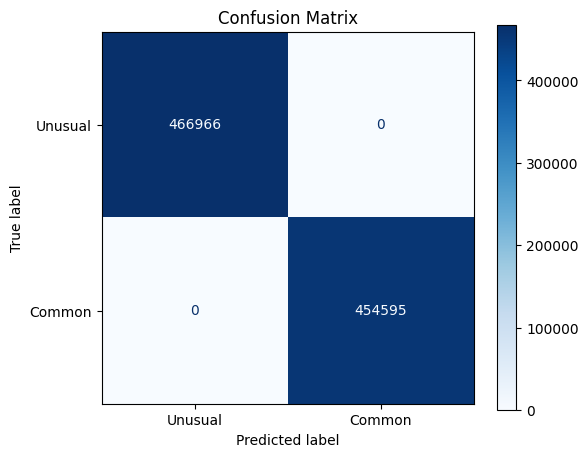

In [59]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unusual", "Common"])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [62]:
# Save model
with open("../data/unusual_paring_model.pkl", "wb") as file:
    pickle.dump(model, file)
    
model.save_model("../data/unusual_paring_model.json")

with open("../data/scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)
# Load model
with open("../data/unusual_paring_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)